In [1]:
!pip install pytrends

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import load_model
from pytrends.request import TrendReq
import time

In [3]:
pytrends = TrendReq(hl='en-US', tz=360)
keywords = ['etude house', 'innisfree', 'laneige', 'kbbq', 'korean cuisine', 'korean food', 'kpop']
df_trends = pd.DataFrame()
max_retries = 3

for keyword in keywords:
    retries = 0
    while retries < max_retries:
        try:
            pytrends.build_payload([keyword], cat=0, timeframe='today 1-m', geo='US-TX', gprop='')
            data = pytrends.interest_over_time()
            if not data.empty:
                weekly_data = data.resample('W').mean()
                df_trends[keyword] = weekly_data[keyword]
            break
        except Exception as e:
            print(f"Error with keyword '{keyword}': {e}. Retrying ({retries + 1}/{max_retries})...")
            
            if retries == max_retries - 1:  
                time.sleep(840)
            else:
                time.sleep(480)
            retries += 1

        if retries == max_retries:
            print(f"Failed to retrieve data for '{keyword}' after {max_retries} attempts. Stopping operation.")
            break
        else:
            time.sleep(480)

    if retries == max_retries:
        break

if retries < max_retries:
    print("Trends Data:", df_trends.head())
else:
    print("Operation stopped due to repeated errors.")

Error with keyword 'laneige': The request failed: Google returned a response with code 429. Retrying (1/3)...
Trends Data:             etude house  innisfree    laneige       kbbq  korean cuisine  \
date                                                                       
2023-10-29    18.500000   0.000000  63.000000  23.500000       50.000000   
2023-11-05     0.000000  31.142857  44.428571  36.857143        0.000000   
2023-11-12    23.714286   0.000000  58.285714  14.285714       41.142857   
2023-11-19     0.000000  27.000000  50.857143  31.285714       12.714286   
2023-11-26    20.000000  51.400000  85.000000  39.600000       10.000000   

            korean food       kpop  
date                                
2023-10-29    63.000000  58.500000  
2023-11-05    54.571429  57.571429  
2023-11-12    42.142857  61.714286  
2023-11-19    50.142857  56.714286  
2023-11-26    66.600000  74.000000  


In [4]:
df_trends.tail()

,etude house,innisfree,laneige,kbbq,korean cuisine,korean food,kpop
date,,,,,,,
2023-10-29,18.500000,0.000000,63.000000,23.500000,50.000000,63.000000,58.500000
2023-11-05,0.000000,31.142857,44.428571,36.857143,0.000000,54.571429,57.571429
2023-11-12,23.714286,0.000000,58.285714,14.285714,41.142857,42.142857,61.714286
2023-11-19,0.000000,27.000000,50.857143,31.285714,12.714286,50.142857,56.714286
2023-11-26,20.000000,51.400000,85.000000,39.600000,10.000000,66.600000,74.000000


In [5]:
def preprocess_data(df, keywords):
    cosmetics_keywords = ['etude house', 'innisfree', 'laneige']
    df['cosmetics'] = df[[kw for kw in cosmetics_keywords if kw in df.columns]].max(axis=1)
    kfood_keywords = ['kbbq', 'korean cuisine', 'korean food']
    df['kfood'] = df[[kw for kw in kfood_keywords if kw in df.columns]].max(axis=1)

    preserved_columns = ['kpop', 'cosmetics', 'kfood']
    df.drop(columns=[kw for kw in keywords if kw in df.columns and kw not in preserved_columns], inplace=True)

    return df

In [6]:
def create_windowed_df(dataframe, n=3):
    X, dates = [], []
    for i in range(len(dataframe) - n + 1):
        x_cosmetics = dataframe['cosmetics'].iloc[i:i+n].values * 0.7
        x_kpop = dataframe['kpop'].iloc[i:i+n].values * 0.15
        x_kfood = dataframe['kfood'].iloc[i:i+n].values * 0.15
        x = np.stack((x_cosmetics, x_kpop, x_kfood), axis=1)
        dates.append(dataframe.index[i+n-1])
        X.append(x)
    return pd.DataFrame({'Date': dates, 'X': X})

In [7]:
def predict_and_plot(model, windowed_df, predictions):
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    actual_dates_series = pd.Series(windowed_df['Date'])

    actual_values = [window[0][0] for window in windowed_df['X']]  # Cosmetics interest values
    plt.plot(actual_dates_series, actual_values, label='Actual', color='blue')

    if len(predictions) > 0:
        last_date = actual_dates_series.iloc[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=len(predictions), freq='W')

        future_dates_series = pd.Series(future_dates)

        plt.plot(future_dates_series, predictions, 'ro-', label='Predictions')

        for i, (date, prediction) in enumerate(zip(future_dates_series, predictions)):
            annotation = f'{prediction:.2f}\n{date.strftime("%Y-%m-%d")}'
            plt.annotate(annotation, (mdates.date2num(date), prediction), textcoords="offset points", xytext=(0,10), ha='center')

    else:
        print("No predictions to plot.")

    all_dates = pd.concat([actual_dates_series, future_dates_series]) if len(predictions) > 0 else actual_dates_series
    ax.set_xlim([all_dates.min(), all_dates.max()])
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.xlabel('Date')
    plt.ylabel('Cosmetics Interest')
    plt.title('Search Trend Prediction')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Shape of X_test: (3, 3, 3)
Model's expected input shape: (None, 3, 3)


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 163ms/step
Predictions: [58.356335 52.922337 65.55444 ]


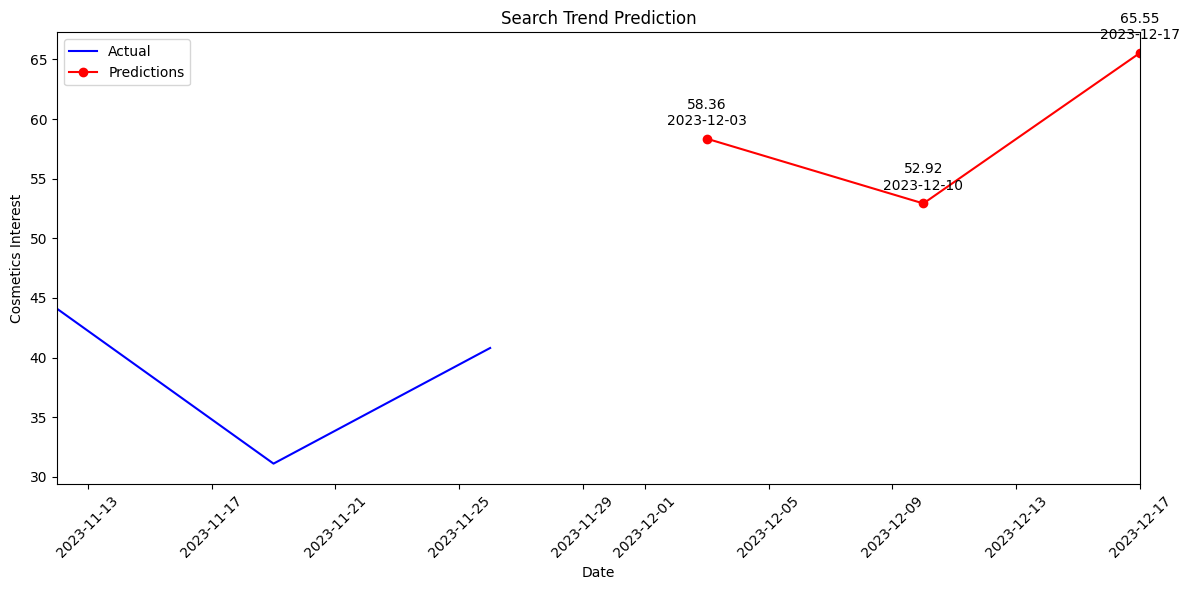

In [8]:
def main():

    tf.config.run_functions_eagerly(True)

    model = load_model('/kaggle/input/ktrendmodel/cosmetics_trend_prediction_model.h5')
    model.compile(run_eagerly=True)

    df_preprocessed = preprocess_data(df_trends, keywords)
    windowed_df = create_windowed_df(df_preprocessed)
    X_test = np.array(windowed_df['X'].tolist())

    print("Shape of X_test:", X_test.shape)
    print("Model's expected input shape:", model.input_shape)

    if np.isnan(X_test).any() or np.isinf(X_test).any():
        raise ValueError("X_test contains NaN or infinite values.")

    predictions = model.predict(X_test).flatten()
    print("Predictions:", predictions)

    predict_and_plot(model, windowed_df, predictions)

if __name__ == "__main__":
    main()